In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import casadi as ca

In [2]:
class StrictSQPSolver:
    def __init__(self, f_func, h_func=None, g_func=None, max_iter=50, tol=1e-6, use_bfgs=False, verbose=False):
        self.f_func = f_func
        self.h_func = h_func
        self.g_func = g_func
        self.max_iter = max_iter
        self.tol = tol
        self.use_bfgs = use_bfgs
        self.verbose = verbose
        self.trace = []

        self.x_dim = f_func.size_in(0)[0]
        self._setup_derivatives()

    def _setup_derivatives(self):
        x = ca.MX.sym('x', self.x_dim)
        self.grad_f = ca.Function('grad_f', [x], [ca.gradient(self.f_func(x), x)])

        if self.h_func is not None:
            self.grad_h = ca.Function('grad_h', [x], [ca.jacobian(self.h_func(x), x)])
        if self.g_func is not None:
            self.grad_g = ca.Function('grad_g', [x], [ca.jacobian(self.g_func(x), x)])

        lmbda_dim = 0
        if self.g_func is not None:
            lmbda_dim += self.g_func(x).size1()
        if self.h_func is not None:
            lmbda_dim += self.h_func(x).size1()

        lmbda = ca.MX.sym('lmbda', lmbda_dim)
        L = self.f_func(x)
        idx = 0
        if self.g_func is not None:
            g_val = self.g_func(x)
            for i in range(g_val.size1()):
                L += lmbda[idx] * g_val[i]
                idx += 1
        if self.h_func is not None:
            h_val = self.h_func(x)
            for i in range(h_val.size1()):
                L += lmbda[idx] * h_val[i]
                idx += 1

        self.hess_L = ca.Function('hess_L', [x, lmbda], [ca.hessian(L, x)[0]])

    def solve(self, x0):
        x_k = np.array(x0).flatten()
        H_k = np.eye(self.x_dim)

        for iteration in range(self.max_iter):
            self.trace.append(x_k.copy())

            grad_f_k = np.array(self.grad_f(x_k).full()).flatten()

            g_val_k, grad_g_k = None, None
            h_val_k, grad_h_k = None, None
            if self.g_func is not None:
                g_val_k = np.array(self.g_func(x_k).full()).flatten()
                grad_g_k = np.array(self.grad_g(x_k).full())
            if self.h_func is not None:
                h_val_k = np.array(self.h_func(x_k).full()).flatten()
                grad_h_k = np.array(self.grad_h(x_k).full())

            if not self.use_bfgs:
                lmbda_input = np.concatenate([
                    np.zeros_like(g_val_k) if g_val_k is not None else [],
                    np.zeros_like(h_val_k) if h_val_k is not None else []
                ])
                H_k = np.array(self.hess_L(x_k, lmbda_input).full())
                H_k = (H_k + H_k.T) / 2

                eigvals = np.linalg.eigvalsh(H_k)
                min_eig = np.min(eigvals)
                if min_eig <= 1e-6:
                    H_k += (abs(min_eig) + 1e-4) * np.eye(H_k.shape[0])

            # Solve QP
            success, d_k, multipliers = self._solve_qp(
                H_k,
                grad_f_k,
                grad_g_k,
                -g_val_k if g_val_k is not None else None,
                grad_h_k,
                -h_val_k if h_val_k is not None else None
            )

            if not success:
                if self.verbose:
                    print(f"[Iter {iteration}] QP solver failed, early stop.")
                break

            if np.linalg.norm(d_k) < self.tol:
                self.trace.append(x_k + d_k)
                if self.verbose:
                    print(f"[Iter {iteration}] Converged, step norm={np.linalg.norm(d_k):.2e}")
                break

            # Line search (backtracking)
            alpha = 1.0
            beta = 0.5
            c1 = 1e-4
            f_current = self.f_func(x_k).full().flatten()[0]
            grad_current = grad_f_k

            while True:
                x_trial = x_k + alpha * d_k
                f_trial = self.f_func(x_trial).full().flatten()[0]
                if f_trial <= f_current + c1 * alpha * np.dot(grad_current, d_k):
                    break
                alpha *= beta
                if alpha < 1e-8:
                    break

            x_next = x_k + alpha * d_k

            if self.use_bfgs:
                s = (x_next - x_k).reshape(-1, 1)
                y = (np.array(self.grad_f(x_next).full()).flatten() - grad_f_k).reshape(-1, 1)
                rho = 1.0 / (y.T @ s + 1e-8)
                V = np.eye(self.x_dim) - rho * s @ y.T
                H_k = V @ H_k @ V.T + rho * s @ s.T

            x_k = x_next

            if self.verbose:
                print(f"[Iter {iteration}] Cost: {f_current:.6f}, alpha={alpha:.3f}, step norm={np.linalg.norm(d_k):.2e}")

        return x_k

    def _solve_qp(self, H, f, A_eq, b_eq, A_ineq, b_ineq):
        x = ca.MX.sym('x', H.shape[1])
        f = f.reshape((1, -1))
        cost = 0.5 * ca.mtimes([x.T, H, x]) + ca.mtimes(f, x)

        constraints = []
        lbg = []
        ubg = []

        if A_eq is not None and A_eq.shape[0] > 0:
            constraints.append(ca.mtimes(A_eq, x) + b_eq)
            lbg.append(np.zeros(A_eq.shape[0]))
            ubg.append(np.zeros(A_eq.shape[0]))

        if A_ineq is not None and A_ineq.shape[0] > 0:
            constraints.append(ca.mtimes(A_ineq, x) + b_ineq)
            lbg.append(np.zeros(A_ineq.shape[0]))
            ubg.append(np.full(A_ineq.shape[0], np.inf))

        if constraints:
            g = ca.vertcat(*constraints)
            lbg = np.concatenate(lbg)
            ubg = np.concatenate(ubg)
        else:
            g = ca.MX()
            lbg = np.array([])
            ubg = np.array([])

        qp = {'x': x, 'f': cost, 'g': g}
        solver = ca.qpsol('solver', 'qpoases', qp, {'error_on_fail': False})
        sol = solver(lbg=lbg, ubg=ubg)

        stats = solver.stats()
        success = not bool(stats['return_status'] == 'Infeasible_Problem_Detected')

        return success, np.array(sol['x'].full()).flatten(), np.array(sol['lam_g'].full()).flatten()


    def plot_trajectory(self, global_minima=None):
        x_max, x_min, y_max, y_min = 2.5, -2.5, 2.5, -2.5
        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        if self.h_func is not None:
            H_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    H_vals[i, j] = self.h_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, H_vals, levels=[0], colors='k', linewidths=2, linestyles='--')

        if self.g_func is not None:
            G_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    G_vals[i, j] = self.g_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, G_vals, levels=[0], colors='b', linewidths=2)
            ax.contourf(X, Y, G_vals, levels=[-np.inf, 0], colors='blue', alpha=0.1)

        if self.trace:
            traj = np.array(self.trace)
            ax.plot(traj[:, 0], traj[:, 1], 'o-', color='orange', label='SQP Trajectory')
            ax.plot(traj[0, 0], traj[0, 1], 'bo', label='Start')
            ax.plot(traj[-1, 0], traj[-1, 1], 'gs', label='End')

        if global_minima is not None:
            ax.plot(global_minima[0], global_minima[1], '*', color='red', markersize=15, label='Global Min')

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("Strict SQP Optimization Trajectory")
        ax.grid(True)
        ax.legend()
        plt.show()



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

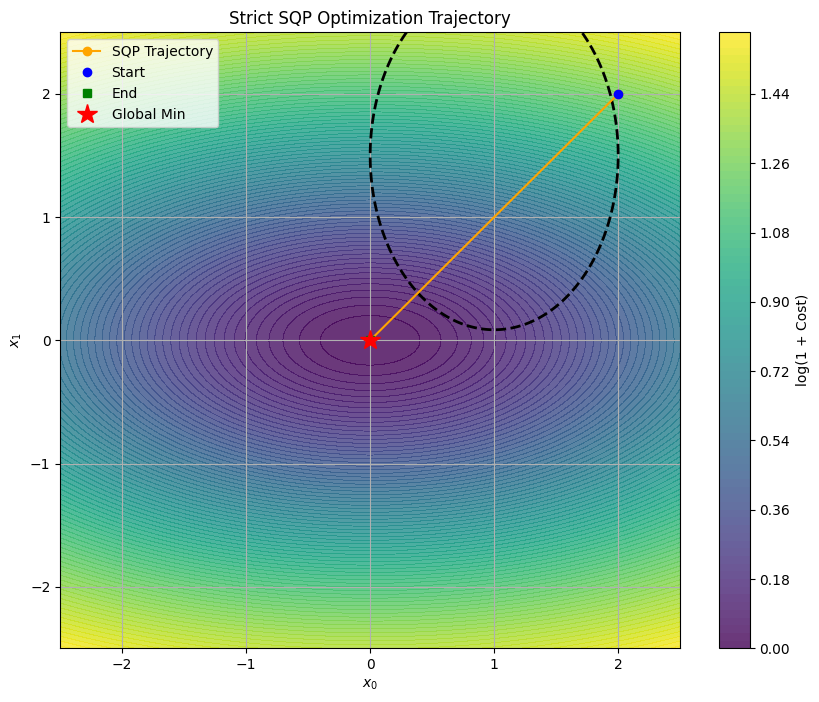

In [3]:
# Define symbols
x = ca.MX.sym('x', 2)

# Objective: simple quadratic
f = ca.Function('f', [x], [0.5 * (x[0]**2 / 4 + x[1]**2)])

# Equality constraint: nonlinear
g = None # ca.Function('g', [x], [x[0] + ca.sin(x[1]) - 1])

# Inequality constraint: elliptical region
h = ca.Function('h', [x], [1 - (x[0] - 1)**2 - (x[1] - 1.5)**2 / 2])

# Instantiate solver
sqp_solver = StrictSQPSolver(
    f_func=f,
    h_func=h,
    g_func=g,
    max_iter=50,
    tol=1e-6,
    use_bfgs=False, 
    verbose=True 
)

# Initial point
x_init = np.array([2.0, 2.0])

# Solve
sol = sqp_solver.solve(x_init)

print("Optimal Solution Found:", sol)

# Plot
sqp_solver.plot_trajectory(global_minima=np.array([0.0, 0.0]))
